In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Question 2

---

#### Find the organs of interest in the provided CT image kidney.jpg. The organs of interest are as shown below.

In [2]:
def find_root(conn, x):
    tmp = x
    while conn[tmp] != 0:
        tmp = conn[tmp]
        
    return tmp

def connected_components(im, neigh):
    im = np.int32(im)
    m, n = im.shape
    
    ret = np.zeros((m, n), dtype=int)
    p = 1
    conn = np.zeros((m*n), dtype=int)
    
    # Pass 1
    for i in range(m):
        for j in range(n):
            if im[i][j] == 1:
                arr = np.zeros(4, dtype=int)
                
                if j-1 >= 0:
                    arr[0] = ret[i][j-1]
                    
                if i-1 >= 0:
                    arr[1] = ret[i-1][j]
                    
                if neigh == 8:
                    if i-1 >= 0 and j-1 >= 0:
                        arr[2] = ret[i-1][j-1]
                        
                    if i-1 >= 0 and j+1 < n:
                        arr[3] = ret[i-1][j+1]
                
                arr = arr[arr != 0]
                
                if arr.shape[0] == 0:
                    ret[i][j] = p
                    p += 1
                else:
                    ret[i][j] = np.min(arr)
                    min_root = find_root(conn, ret[i][j])
                    
                    rep = arr[arr != ret[i][j]]
                    rep = np.unique(rep)
                    
                    if rep.shape[0] == 0:
                        continue
                        
                    for k in rep:
                        k_root = find_root(conn, k)
                        
                        if k_root != min_root:
                            conn[k_root] = ret[i][j]
                        
    # Pass 2
    for i in range(m):
        for j in range(n):
            if im[i][j] == 1:
                ret[i][j] = find_root(conn, ret[i][j])
                
    labels = np.unique(ret)
    for i in range(len(labels)):
        ret[ret == labels[i]] = i
    
    return labels.shape[0], ret

In [8]:
def erosion(im, se):
    im = np.int32(im)
    m, n = im.shape
    k, l = se.shape
    
    im = np.vstack((np.zeros(((k-1)//2, n+l-1)), np.hstack((np.zeros((m, (l-1)//2)), im, np.zeros((m, (l-1)//2)))), np.zeros(((k-1)//2, n+l-1))))
    ret = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            ret[i][j] = np.min(im[i:i+k, j:j+l][se == 1])
            
    return ret

def dilation(im, se):
    im = np.int32(im)
    m, n = im.shape
    k, l = se.shape
    
    im = np.vstack((np.zeros(((k-1)//2, n+l-1)), np.hstack((np.zeros((m, (l-1)//2)), im, np.zeros((m, (l-1)//2)))), np.zeros(((k-1)//2, n+l-1))))
    ret = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            ret[i][j] = np.max(im[i:i+k, j:j+l][se == 1])
            
    return ret

def circle_kernel(x):
    k, l = np.meshgrid(np.arange(x), np.arange(x))
    k = k - np.mean(k, axis=1)
    l = l - np.mean(l, axis=0)
    
    ret = np.sqrt(k**2 + l**2)
    
    return np.where(ret <= x//2, 1, 0)

def disc_kernel(x):
    out_k = circle_kernel(x)
    in_k = np.vstack((np.zeros((1, x)), np.hstack((np.zeros((x-2, 1)), circle_kernel(x-2), np.zeros((x-2, 1)))), np.zeros((1, x))))
    
    return out_k - in_k

In [9]:
def imshow_components(labels):
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

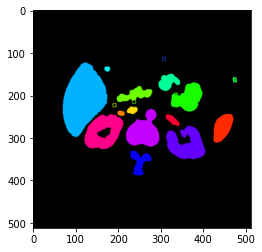

In [21]:
im = cv2.imread('../images/kidney.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(im, 130, 1, cv2.THRESH_BINARY)

kernel = disc_kernel(11)
opening = dilation(erosion(thresh, kernel), kernel)

kernel = disc_kernel(5)
closing = erosion(dilation(opening, kernel), kernel)

num_labels, labels_im = connected_components(closing, 8)

imshow_components(labels_im)